# Crypto Currency Predicitons
Team members:

* Julio Oliveira
* Manish Ranjan
* Rachana Sooraj 

In [238]:
import math
import copy
import pickle
import numpy as np
import pandas as pd
from fitter import Fitter
from sklearn.pipeline import Pipeline
from pygam import  GammaGAM, LogisticGAM
from tensorflow.keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.dummy import DummyClassifier, DummyRegressor
from tensorflow.keras.layers import Dropout, Dense, LSTM
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier



import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter


pio.renderers
np.random.seed(42)
from tensorflow.random import set_seed
set_seed(42)

In [71]:
coins = ['bitcoin', 'ethereum', 'cardano']

We first load the 3 datasets for each of the coins

In [72]:
bitcoin = pd.read_csv('../data/external/bitcoin.csv', parse_dates=['Date'])
cardano = pd.read_csv('../data/external/cardano.csv', parse_dates=['Date'])
ethereum = pd.read_csv('../data/external/ethereum.csv', parse_dates=['Date'])

df = pd.concat([bitcoin, cardano, ethereum], axis=0)

In [73]:
df.shape

(6525, 10)

In [74]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


Total or records for each coin.

In [75]:
df.value_counts(['Symbol'])

Symbol
BTC       2991
ETH       2160
ADA       1374
dtype: int64

In [76]:
df.dtypes

SNo                   int64
Name                 object
Symbol               object
Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Marketcap           float64
dtype: object

## Data Exploration

Now lets look into some metrics for each of the coins

### Bitcoin

In [77]:
print(
    f"Min Date: {df[df.Symbol == 'BTC'].Date.min()}, Max Date: {df[df.Symbol == 'BTC'].Date.max()}"
)


Min Date: 2013-04-29 23:59:59, Max Date: 2021-07-06 23:59:59


In [78]:
df[df.Symbol == 'BTC'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


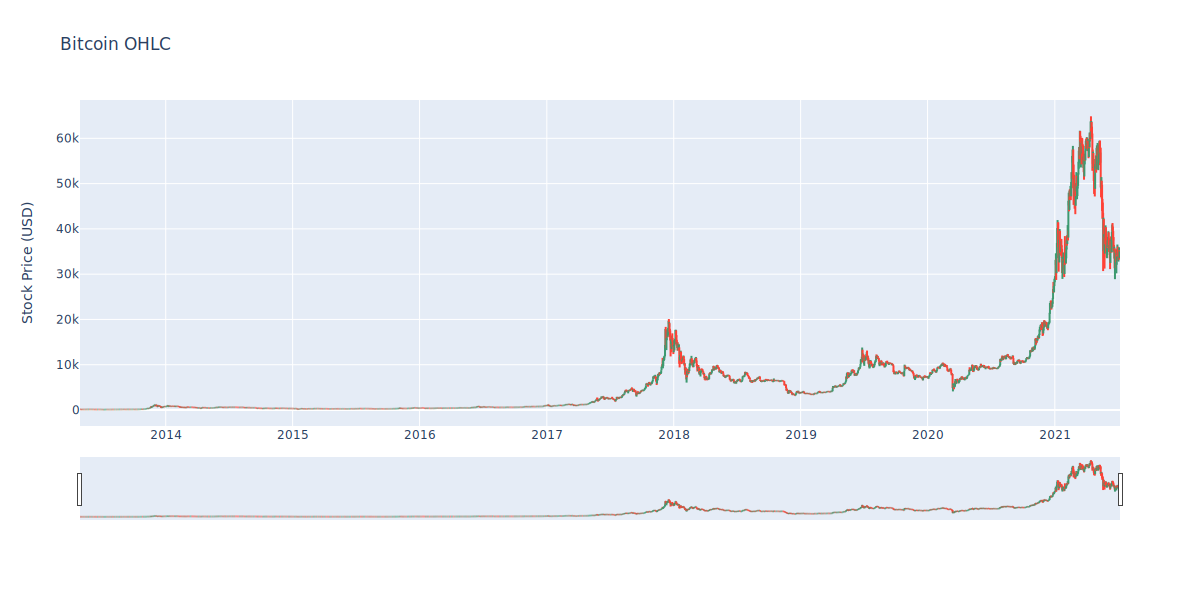

In [79]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'BTC']['Date'],
                             open=df[df.Symbol == 'BTC']['Open'],
                             high=df[df.Symbol == 'BTC']['High'],
                             low=df[df.Symbol == 'BTC']['Low'],
                             close=df[df.Symbol == 'BTC']['Close']))
fig.update_layout(title='Bitcoin OHLC', yaxis_title='Stock Price (USD)',height=600, width=1200)
fig.show(renderer="svg")

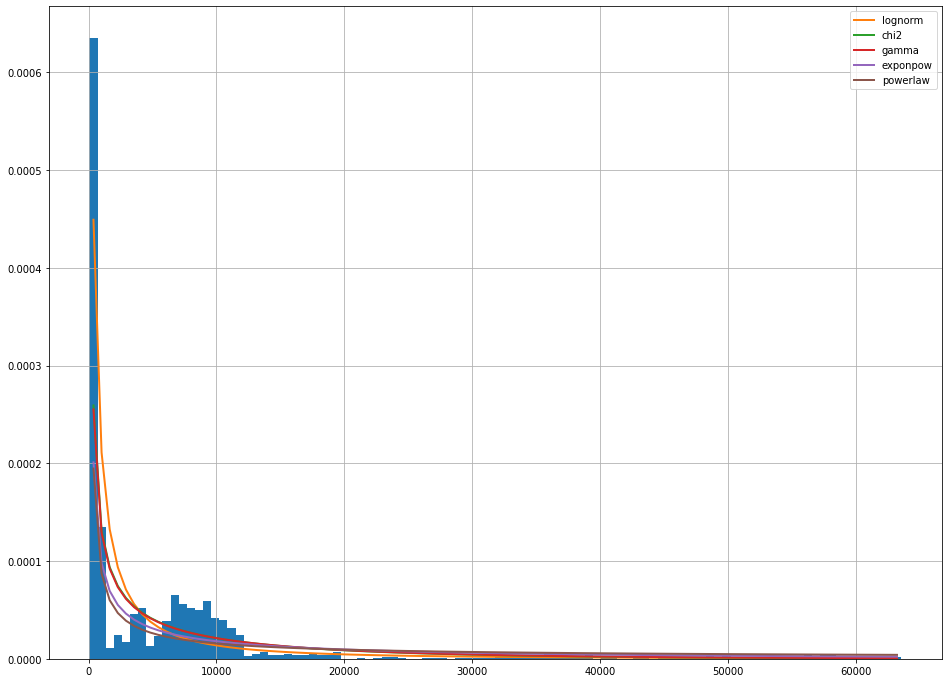

In [80]:
f = Fitter(df[df.Symbol == 'BTC']['Close'], distributions='common')
f.fit()
results = f.summary()

## Cardano

In [81]:
print(
    f"Min Date: {df[df.Symbol == 'ADA'].Date.min()}, Max Date: {df[df.Symbol == 'ADA'].Date.max()}"
)


Min Date: 2017-10-02 23:59:59, Max Date: 2021-07-06 23:59:59


In [82]:
df[df.Symbol == 'ADA'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1.374000e+03,1.374000e+03
mean,687.500000,0.269807,0.239710,0.255287,0.256313,8.934183e+08,7.603454e+09
std,396.783946,0.433523,0.380928,0.408456,0.409691,2.107653e+09,1.303878e+10
min,1.000000,0.021050,0.017620,0.018414,0.018539,1.739460e+06,4.806646e+08
25%,344.250000,0.047565,0.044601,0.045898,0.045947,5.014830e+07,1.191263e+09
50%,687.500000,0.090274,0.083164,0.086867,0.087002,1.186742e+08,2.270889e+09
75%,1030.750000,0.194519,0.172442,0.181374,0.183379,4.875977e+08,5.174547e+09
max,1374.000000,2.461766,2.013285,2.300190,2.309113,1.914198e+10,7.377224e+10


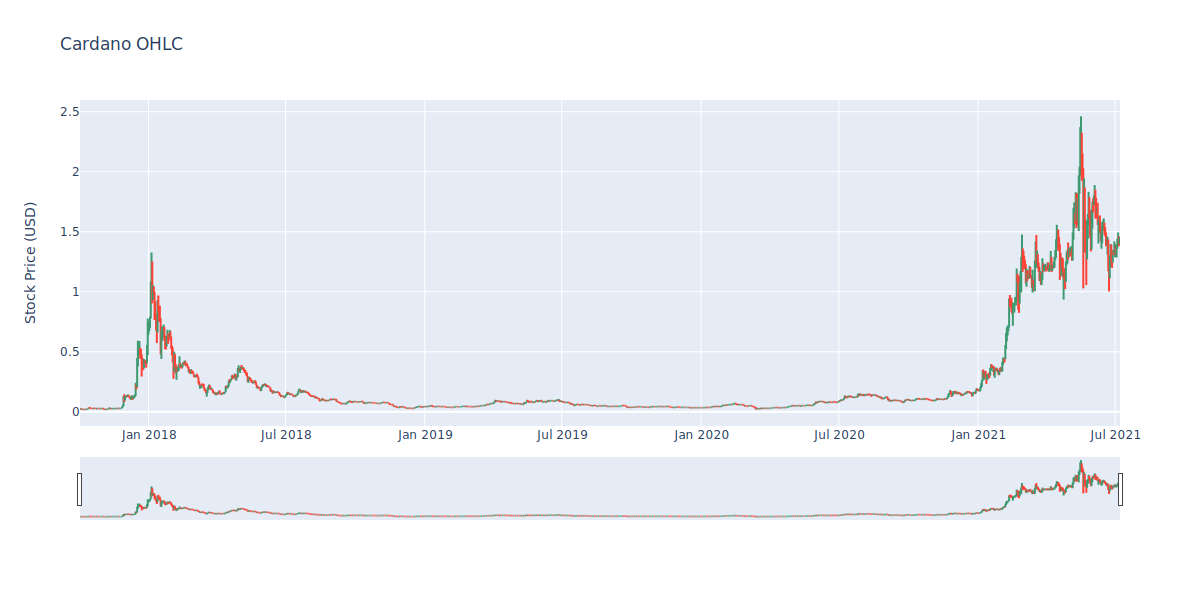

In [83]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'ADA']['Date'],
                             open=df[df.Symbol == 'ADA']['Open'],
                             high=df[df.Symbol == 'ADA']['High'],
                             low=df[df.Symbol == 'ADA']['Low'],
                             close=df[df.Symbol == 'ADA']['Close']))
fig.update_layout(title='Cardano OHLC', yaxis_title='Stock Price (USD)',height=600, width=1200)
fig.show(renderer="svg")

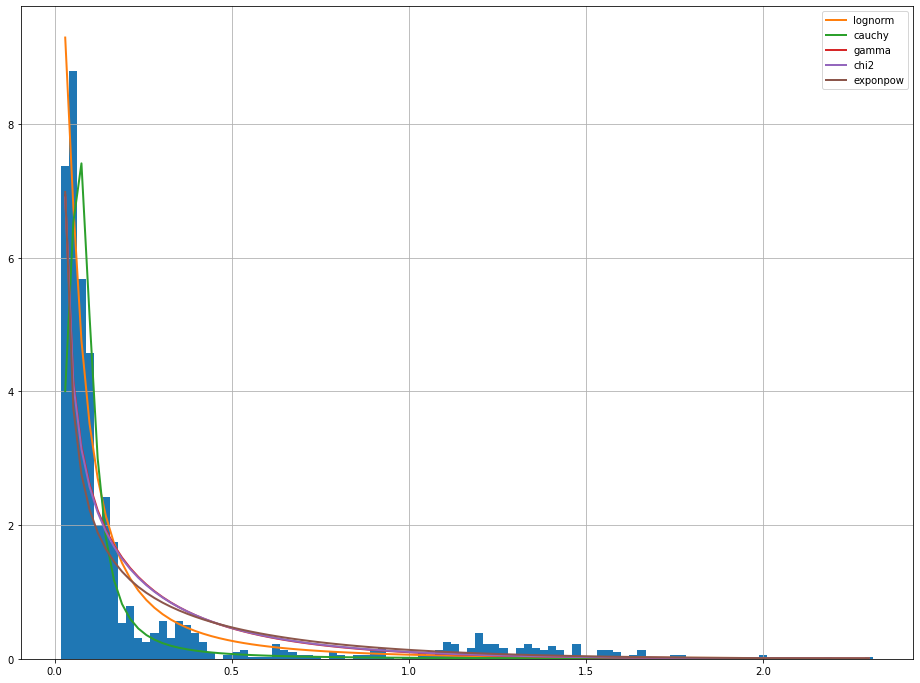

In [84]:
f = Fitter(df[df.Symbol == 'ADA']['Close'], distributions='common')
f.fit()
result = f.summary()

## Ethereum

In [85]:
print(
    f"Min Date: {df[df.Symbol == 'ETH'].Date.min()}, Max Date: {df[df.Symbol == 'ETH'].Date.max()}"
)


Min Date: 2015-08-08 23:59:59, Max Date: 2021-07-06 23:59:59


In [86]:
df[df.Symbol == 'ETH'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2.160000e+03,2.160000e+03
mean,1080.500000,398.258568,365.592589,382.879899,383.910691,7.057058e+09,4.172084e+10
std,623.682612,628.082281,566.611523,599.719862,601.078766,1.064526e+10,6.909184e+10
min,1.000000,0.482988,0.420897,0.431589,0.434829,1.021280e+05,3.221363e+07
25%,540.750000,14.265225,13.190950,13.757600,13.819200,3.825102e+07,1.135576e+09
50%,1080.500000,205.124631,193.302715,198.425096,198.643691,2.148880e+09,2.070063e+10
75%,1620.250000,396.494561,375.146804,386.264935,386.435272,9.629136e+09,4.231010e+10
max,2160.000000,4362.350542,3785.848603,4174.635873,4168.701049,8.448291e+10,4.828819e+11


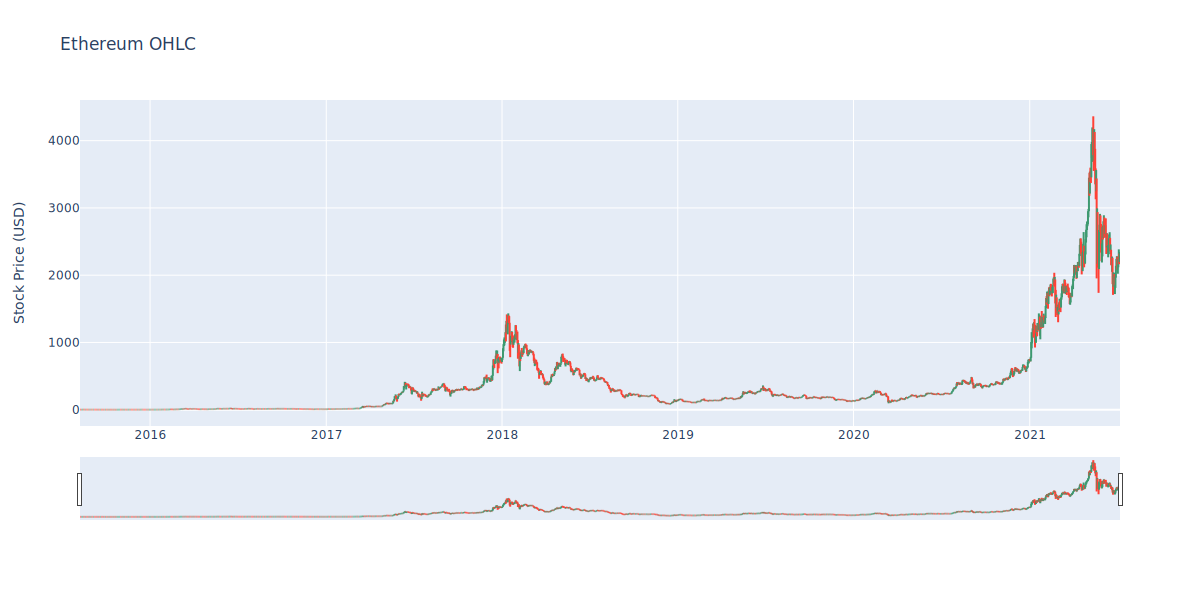

In [87]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'ETH']['Date'],
                             open=df[df.Symbol == 'ETH']['Open'],
                             high=df[df.Symbol == 'ETH']['High'],
                             low=df[df.Symbol == 'ETH']['Low'],
                             close=df[df.Symbol == 'ETH']['Close']))
fig.update_layout(title='Ethereum OHLC', yaxis_title='Stock Price (USD)',height=600, width=1200)
fig.show(renderer="svg")

,sumsquare_error,aic,bic,kl_div
lognorm,0.000026,1886.671939,-39071.431670,inf
gamma,0.000030,1882.031273,-38774.981782,inf
chi2,0.000030,1890.136254,-38753.695149,inf


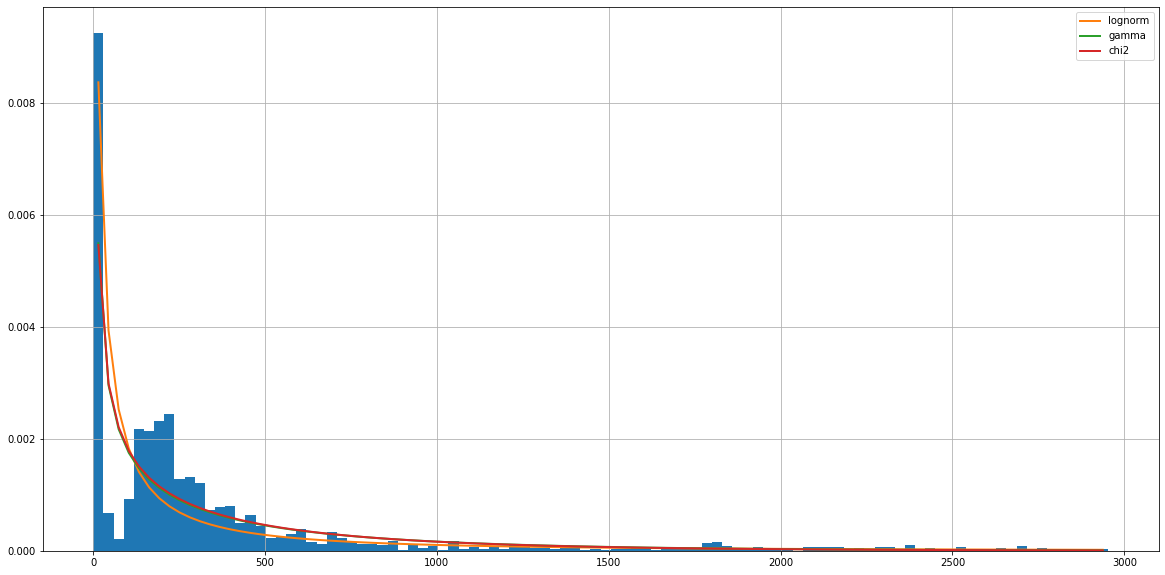

In [88]:
f = Fitter(df[df.Symbol == 'ETH']['Close'], distributions='common',xmax=3000)
plt.figure(figsize=(20, 10))
f.fit()
f.summary(Nbest=3)

### Seasonality




<built-in method title of str object at 0x7f49812251f0>


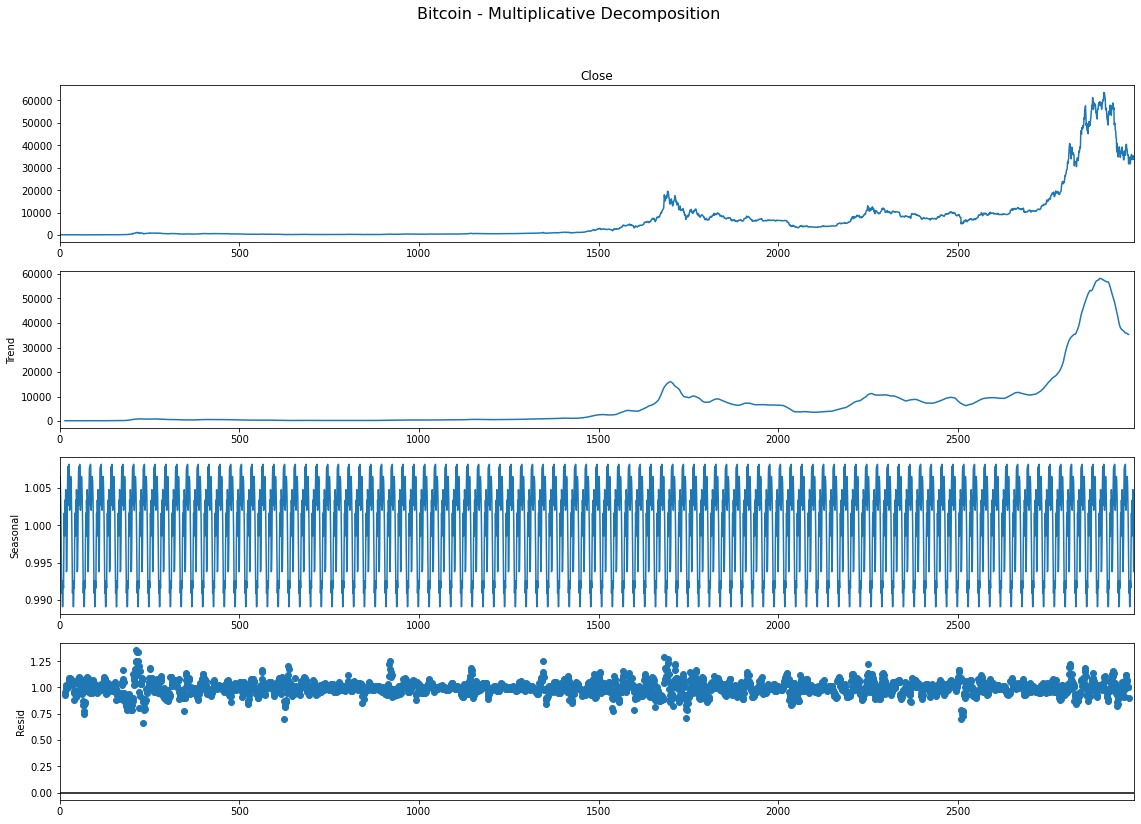

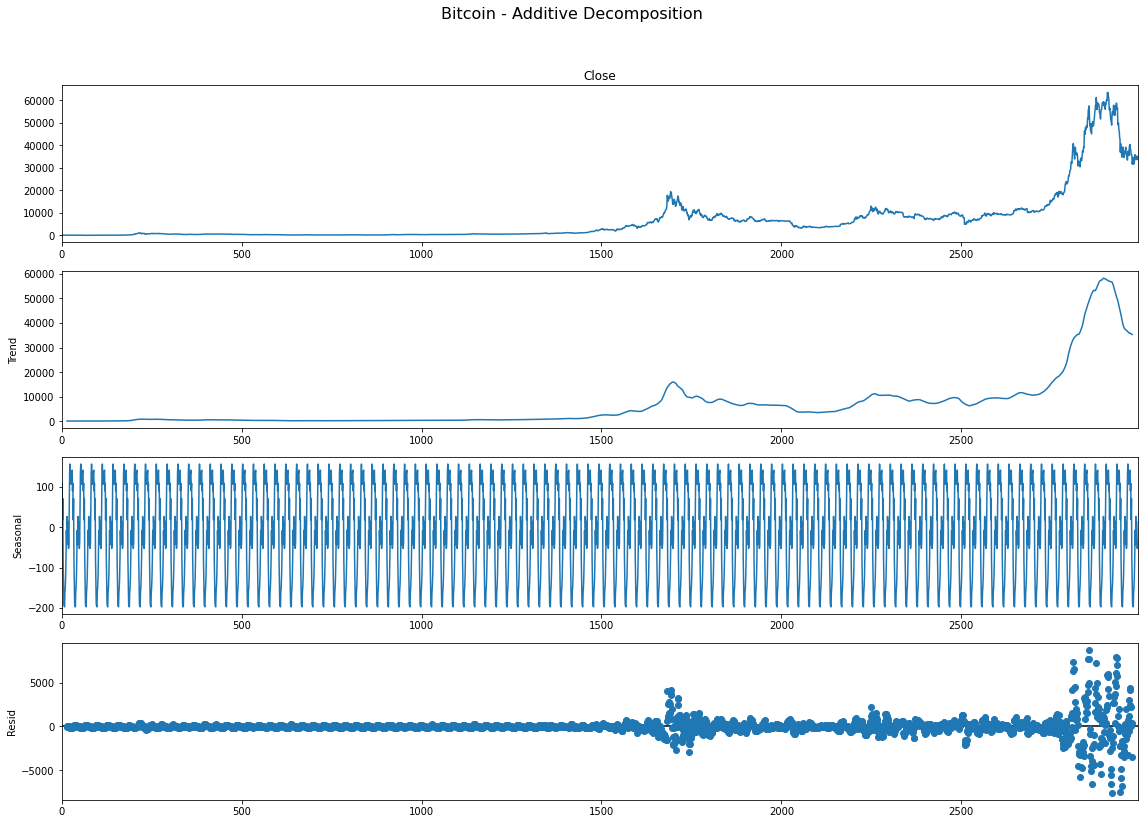




<built-in method title of str object at 0x7f49636b3bb0>


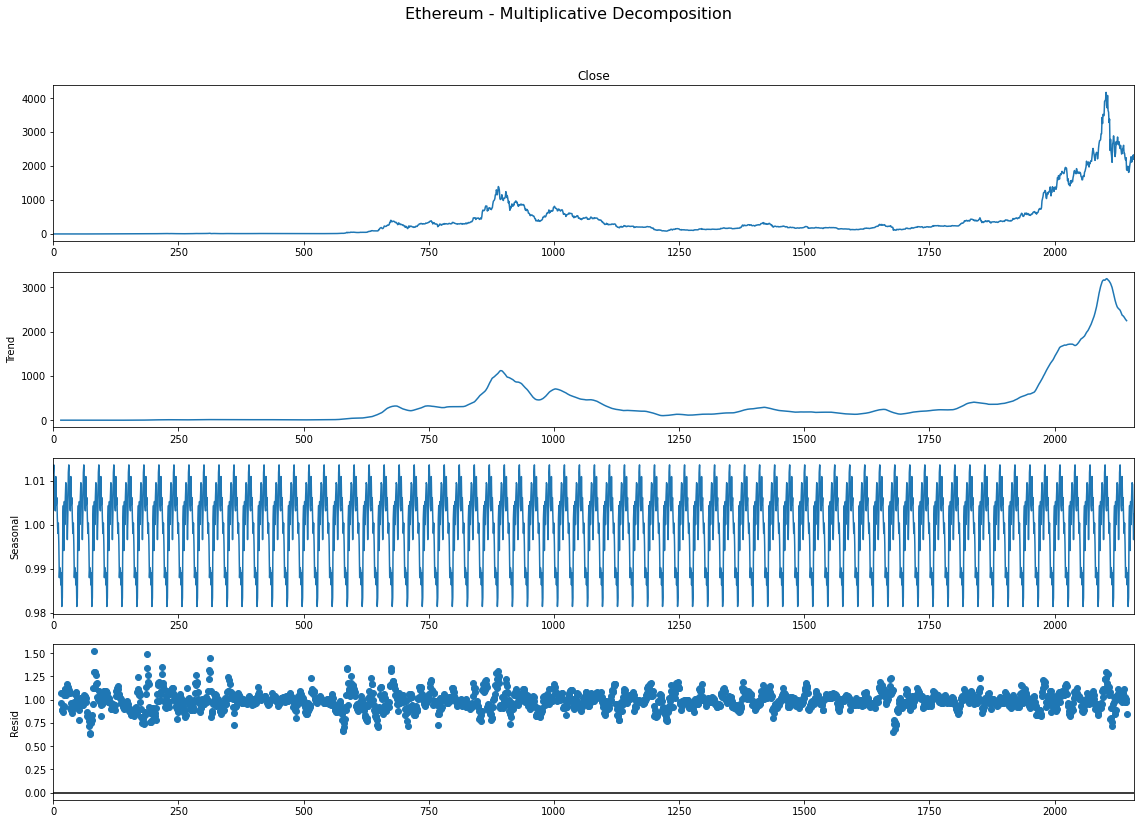

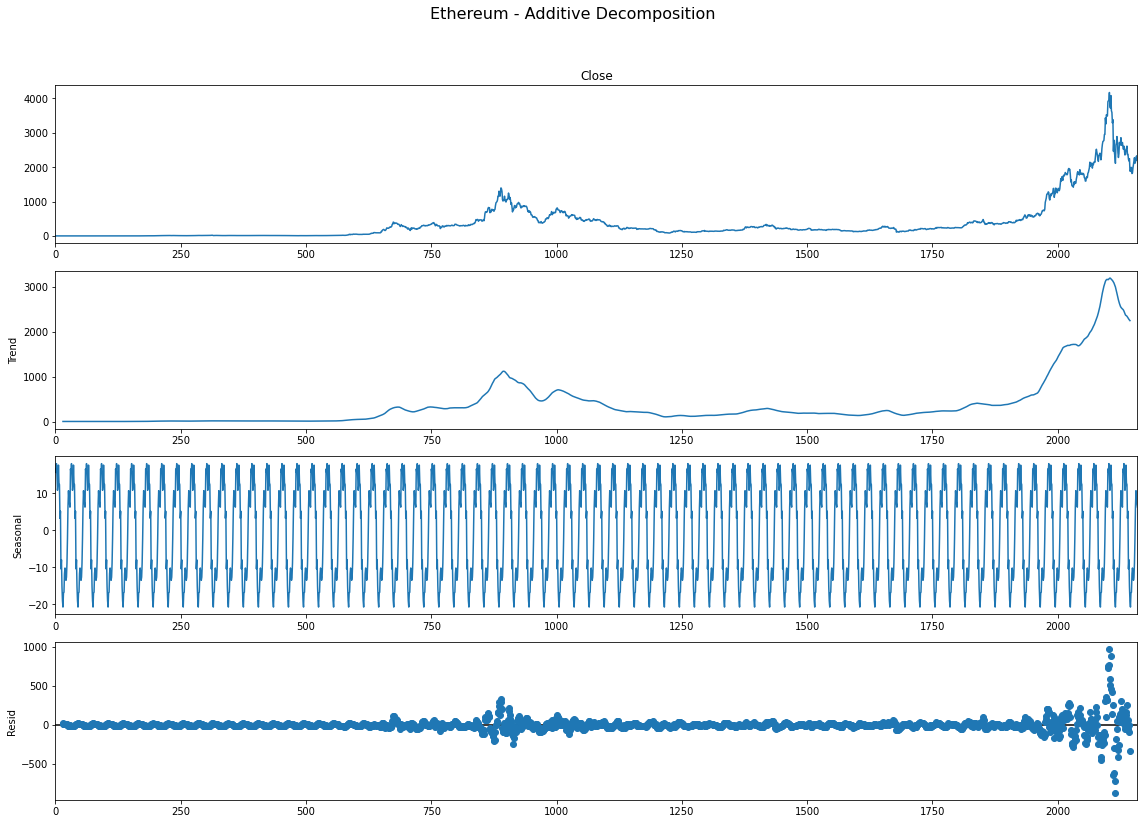




<built-in method title of str object at 0x7f4962ba65f0>


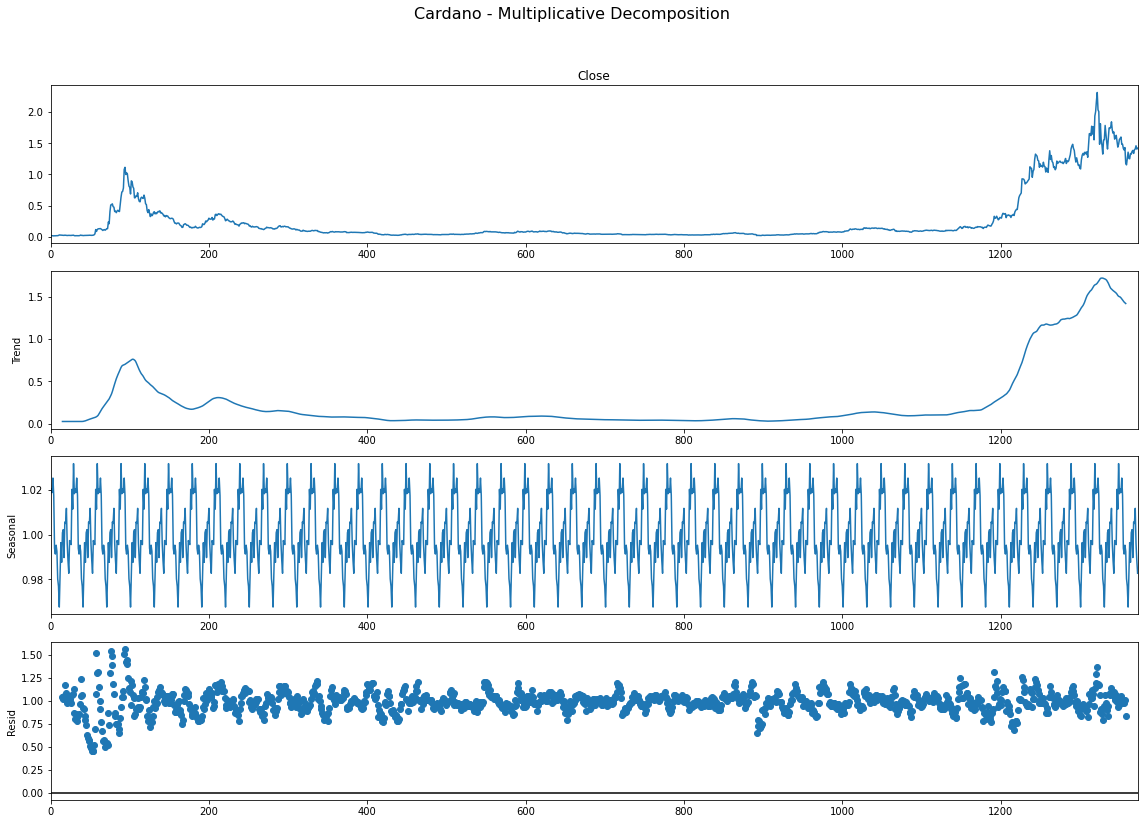

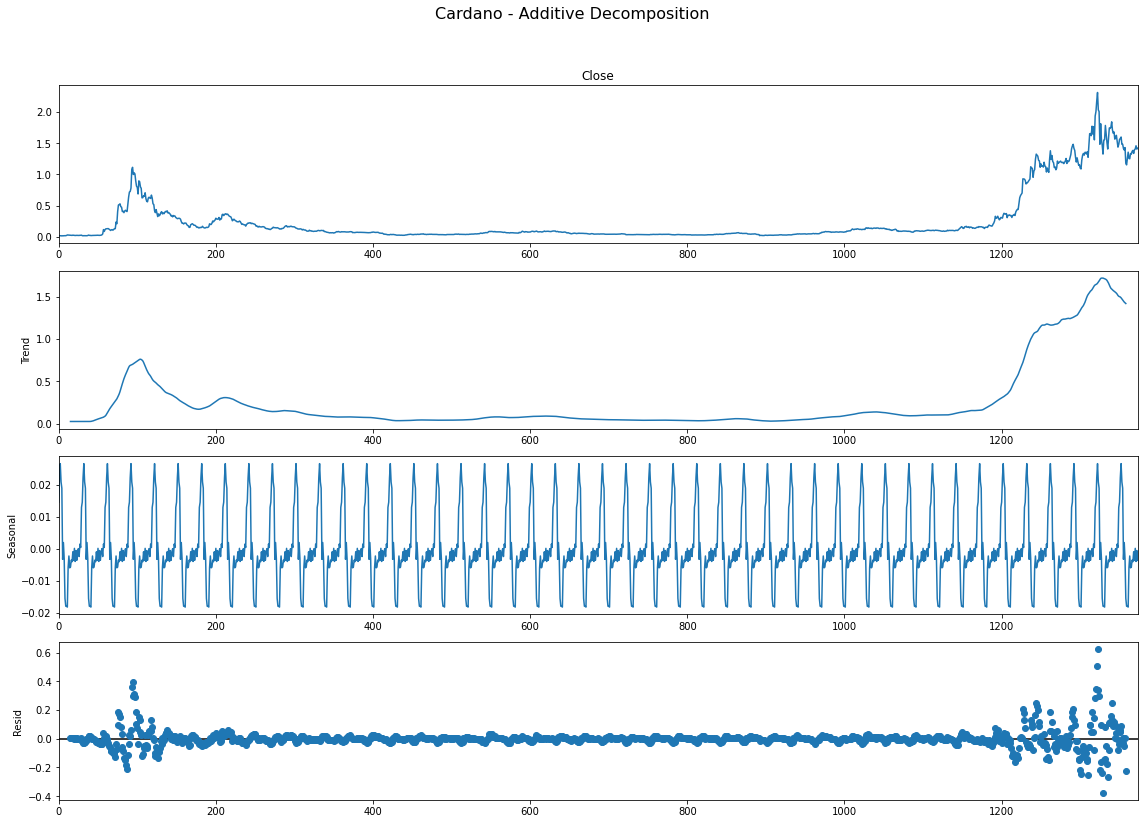

In [89]:
def plot_decompose(df: pd.DataFrame, coin: str, col):
    multiplicative_decomposition = seasonal_decompose(df[col],
                                                      model='multiplicative',
                                                      period=30)

    additive_decomposition = seasonal_decompose(df[col],
                                                model='additive',
                                                period=30)

    plt.rcParams.update({'figure.figsize': (16, 12)})
    multiplicative_decomposition.plot().suptitle(
        f'{coin.title()} - Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    additive_decomposition.plot().suptitle(
        f'{coin.title()} - Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


for col in coins:
    print(f'\n\n\n{col.title}')
    plot_decompose(df[df.Name == col.title()], col, 'Close')


## Train Test Split

In order to train our model we need all the information from the 3 coins grouped by date of occurrence. We have created a script to generate this dataset(src/data/make_dataset.py). The script will output the processed dataset into /data/processed/dataset.csv.

In [90]:
processed_df = pd.read_csv('../data/processed/dataset.csv',
                           parse_dates=['date'])
processed_df.head()

,date,bitcoin_sno,bitcoin_high,bitcoin_low,bitcoin_open,bitcoin_close,bitcoin_volume,bitcoin_marketcap,ethereum_sno,ethereum_high,...,ethereum_close,ethereum_volume,ethereum_marketcap,cardano_sno,cardano_high,cardano_low,cardano_open,cardano_close,cardano_volume,cardano_marketcap
0,2013-04-29 23:59:59,1,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-30 23:59:59,2,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-05-01 23:59:59,3,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-05-02 23:59:59,4,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-03 23:59:59,5,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we are using information from the 3 coins, we need to select only the period of time with information for all 3 criptocurrencies. The newest coin is Cardano with stock price information since '2017-10-02'. Therefore, we define this date as the minimum date for our project.

For a fair evaluation of the models performance, we select a holdout dataset using a out of time strategy starting on '2021-04-01'. The final result of train and test dataset are:

* TRAIN: 2017-10-02 to 2021-04-01
* TEST: 2021-04-01 to 2021-07-06

In [91]:
MIN_DATE = '2017-10-02'
TRAIN_TEST_THRESHOLD = '2021-04-01'
train = processed_df[(processed_df.date < TRAIN_TEST_THRESHOLD)
                     & (processed_df.date >= MIN_DATE)]
test = processed_df[(processed_df.date >= TRAIN_TEST_THRESHOLD)
                    & (processed_df.date >= MIN_DATE)]
print(
    f'Train: {train.shape}, Test: {test.shape}, Proportion: {train.shape[0] / (train.shape[0] + test.shape[0]):.2%}'
)

Train: (1277, 22), Test: (97, 22), Proportion: 92.94%


In [92]:
train.isna().sum()

date                  0
bitcoin_sno           0
bitcoin_high          0
bitcoin_low           0
bitcoin_open          0
bitcoin_close         0
bitcoin_volume        0
bitcoin_marketcap     0
ethereum_sno          0
ethereum_high         0
ethereum_low          0
ethereum_open         0
ethereum_close        0
ethereum_volume       0
ethereum_marketcap    0
cardano_sno           0
cardano_high          0
cardano_low           0
cardano_open          0
cardano_close         0
cardano_volume        0
cardano_marketcap     0
dtype: int64

## Feature Engineering

### Columns Selection

In [93]:
class ColumnDropTransformer():
    """ Sklearn Pipeline transformer for dropping columns from a dataframe """

    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self


Selecting cols that should be used for normalization and cols to drop.

In [94]:
normalize_cols = []
for coin in coins:
    for col in ['open', 'high', 'low', 'close', 'volume', 'marketcap']:
        normalize_cols.append(f'{coin}_{col}')

drop_cols = []
for coin in coins:
    for col in ['sno']:
        drop_cols.append(f'{coin}_{col}')
drop_cols.append('date')

For better reproductibily we create a Sklear Pipeline with the data transformation steps.

In [95]:
minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])

pipeline = Pipeline([
    ("column_dropper", ColumnDropTransformer(drop_cols)),
    ('normalization',
     ColumnTransformer(remainder='passthrough',
                       transformers=[('norm', minmax_transformer,
                                      normalize_cols)],
                       verbose_feature_names_out=True))
])

In [96]:
X_train = pipeline.fit_transform(train)
X_test = pipeline.transform(test)

In [97]:
feature_names = list(pipeline["normalization"].get_feature_names_out())

### Coins Correlation

Now that we have all the coin prices normalized we can plot the price of all coins together.

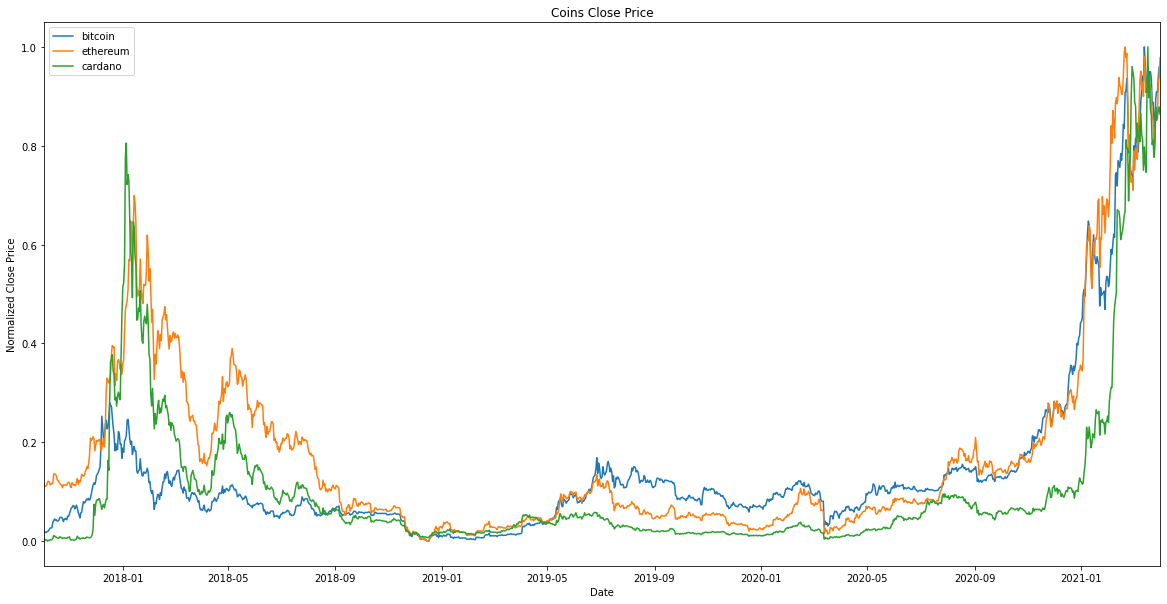

In [98]:
fig, ax = plt.subplots(figsize=(20, 10))

for coin in coins:
    ax.plot(train["date"],
            X_train[:, feature_names.index(f'norm__{coin}_close')],
            label=coin)
ax.set(xlabel="Date",
       ylabel="Normalized Close Price",
       title="Coins Close Price",
       xlim=[min(train["date"]), max(train["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

### Correlation test

Looking into the correlation plot we can notice the Etheureum close price has the highest correlation with the other coins open price. Therefore we decided to predict the ethereum close price.

Moreover, we can identify multicolinearity between the open price features. Therefore we can discard the application of methods with no multicolinearity assumption, such as Linear Regression.

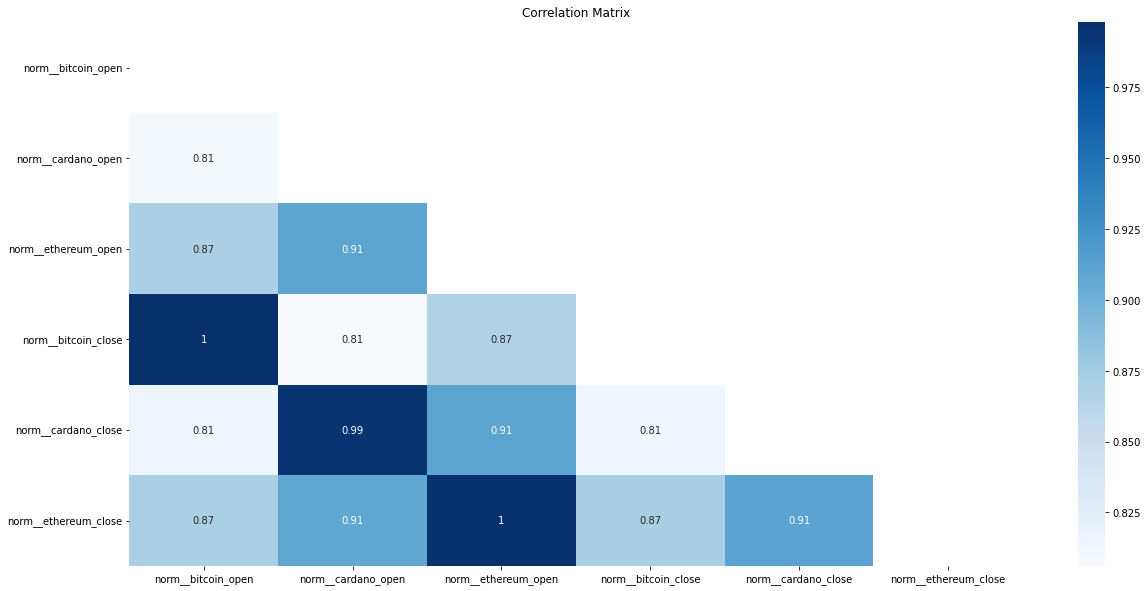

In [99]:
corr_cols = [
    'norm__bitcoin_open', 'norm__cardano_open', 'norm__ethereum_open',
    'norm__bitcoin_close', 'norm__cardano_close', 'norm__ethereum_close'
]
corr_cols_index = [feature_names.index(col) for col in corr_cols]
corr_dataframe = pd.DataFrame(X_train[:, corr_cols_index],
                              columns=corr_cols,
                              dtype=np.float64)
mask = np.triu(corr_dataframe.corr())
plt.figure(figsize=(20,10))
sns.heatmap(corr_dataframe.corr(),
            mask=mask,
            xticklabels=True,
            yticklabels=True,
            cmap='Blues',
            annot=True)
plt.title('Correlation Matrix')
plt.show()

### Stationary Test

We ran Augmented Dickey Fuller test to check for stationary on all open and close price. In the report belowe, we can notice that all the p-value are high, making the assumption for the data being the generated from a stationary distribution false. Therefore, we can not apply strategies that requires stationary distributions such as ARIMA on this dataset.

In [100]:
response_string = "adf: {0:.4f}, p-value: {1:.4f}, usedlag: {2}, nobs: {3}, critical_values: {4}"

results_cols = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical values']

for col in corr_cols:
    col_index = feature_names.index(col)
    adf_results = adfuller(X_train[:, col_index])
    print(f"\n---------\n{col}\n{response_string.format(*adf_results)}")


---------
norm__bitcoin_open
adf: 3.8634, p-value: 1.0000, usedlag: 20, nobs: 1256, critical_values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}

---------
norm__cardano_open
adf: -1.1591, p-value: 0.6909, usedlag: 22, nobs: 1254, critical_values: {'1%': -3.4355754676859886, '5%': -2.8638475772391665, '10%': -2.5679985805677017}

---------
norm__ethereum_open
adf: 0.6970, p-value: 0.9898, usedlag: 22, nobs: 1254, critical_values: {'1%': -3.4355754676859886, '5%': -2.8638475772391665, '10%': -2.5679985805677017}

---------
norm__bitcoin_close
adf: 3.8429, p-value: 1.0000, usedlag: 20, nobs: 1256, critical_values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}

---------
norm__cardano_close
adf: -0.9426, p-value: 0.7736, usedlag: 23, nobs: 1253, critical_values: {'1%': -3.4355796466416777, '5%': -2.863849421064024, '10%': -2.5679995625056926}

---------
norm__ethereum_close
adf: 1.0059, p-value: 0.9943, usedlag: 

### Modeling

***Dependant Variables:***
* bitcoin_open
* cardano_open
* ethereum_open

***Target Variable***
* ethereum_close

In [101]:
model_cols = [
    'norm__bitcoin_open', 'norm__cardano_open', 'norm__ethereum_open'
]
model_cols_id = [feature_names.index(col) for col in model_cols]
y_train = train["ethereum_close"]
X_train = X_train[:, model_cols_id]
y_test = test["ethereum_close"]
X_test = X_test[:, model_cols_id]

In [102]:
def calculate_reg_metrics(model_name, y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model_name} MSE: {mse:.2f}, RMSE: {rmse:.2f}, r2_score: {r2:.2f}")
    return mse, rmse, r2

def _evaluate_reg_model(model, X_train, y_train, X_test, y_test):
    """ Evaluate regression model performance on test dataset"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return calculate_reg_metrics(str(model),y_pred, y_test)

def evaluate_reg_models(models, X_train, y_train, X_test, y_test):
    """ Evaluate multiple regression models on test dataset"""
    results = []
    for model in models:
        mse, rmse, r2 = _evaluate_reg_model(model, X_train, y_train, X_test, y_test)
        results.append((str(model), mse, rmse, r2))
    return pd.DataFrame(results, columns=['model', 'mse', 'rmse', 'r2'])

As we identified above the dataset does not meet the assumptions for Linear Regression models. Therefore, we tested non-linear strategies such as GammaGAM, RandomForestRegressor and GradientBoostingRegressor.

In [103]:
models = [
    GammaGAM(),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
]
evaluate_reg_models(models, X_train, y_train, X_test, y_test)

Model: GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False) MSE: 226471.81, RMSE: 475.89, r2_score: 0.27
Model: RandomForestRegressor(random_state=42) MSE: 783445.71, RMSE: 885.12, r2_score: -1.53
Model: GradientBoostingRegressor(random_state=42) MSE: 815210.21, RMSE: 902.89, r2_score: -1.63


,model,mse,rmse,r2
0,"GammaGAM(callbacks=[Deviance(), Diffs()], fit_...",226471.811152,475.890545,0.269823
1,RandomForestRegressor(random_state=42),783445.711280,885.124687,-1.525939
2,GradientBoostingRegressor(random_state=42),815210.211853,902.889922,-1.628352


Comparing the RMSE values for the holdout dataset we can see that the best results was obtained by the GammaGAM estimator.

In [104]:
class DummyOpenPrice:
    """ Dummy classifier that will always predict the close price to be the same as the open price """
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        """ Return the ethereum open price for each row in X. """
        return X[:, 2]
    
    def __repr__(self):
        return "Dummy Ethereum Open Price"

dummy_models = [DummyRegressor(), DummyRegressor(strategy='median'), DummyOpenPrice()]
evaluate_reg_models(dummy_models, X_train, y_train, X_test, y_test)

Model: DummyRegressor() MSE: 4959223.15, RMSE: 2226.93, r2_score: -14.99
Model: DummyRegressor(strategy='median') MSE: 5655735.95, RMSE: 2378.18, r2_score: -17.23
Model: Dummy Ethereum Open Price MSE: 6929742.37, RMSE: 2632.44, r2_score: -21.34


,model,mse,rmse,r2
0,DummyRegressor(),4.959223e+06,2226.931331,-14.989230
1,DummyRegressor(strategy='median'),5.655736e+06,2378.179125,-17.234884
2,Dummy Ethereum Open Price,6.929742e+06,2632.440383,-21.342459


### GAM

Even tough the GAM predicitons are not better than our Dummy estimator, lets evaluate if it able to learn the prices trend and how are the holdout prediction in a plot compared with the observed data.

In [105]:
gam = GammaGAM()
gam.fit(X_train, y_train)
pickle.dump(gam, open('../models/gam.pkl', 'wb'))

GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 1152x864 with 0 Axes>

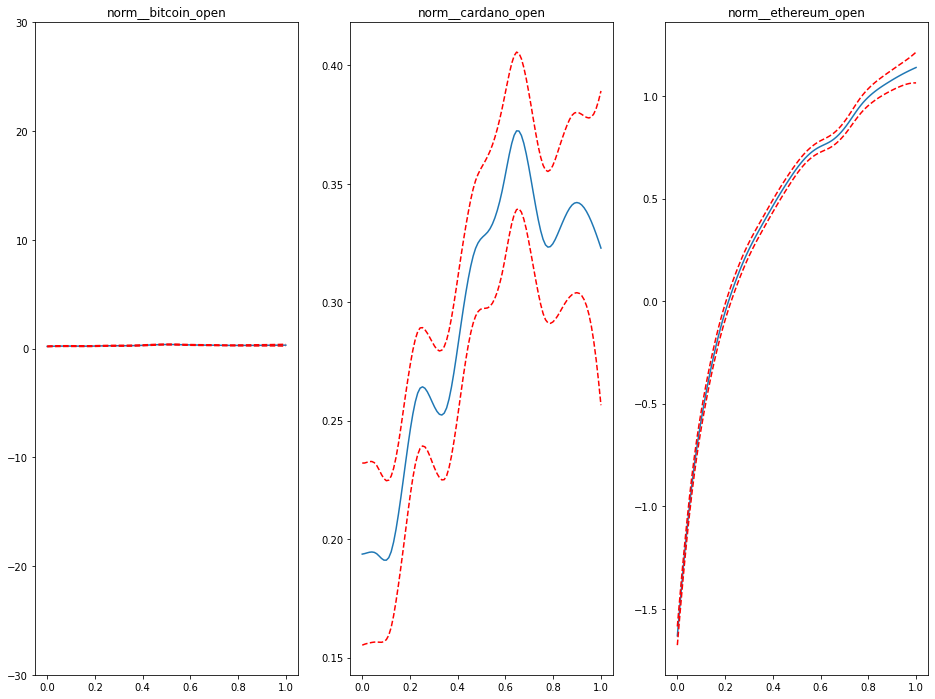

In [106]:
plt.figure()
fig, axs = plt.subplots(1,3)

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(model_cols[i])

In [107]:
gam_predictions_train = gam.predict(X_train)
gam_predictions_test = gam.predict(X_test)
dummy_predictions_train = DummyOpenPrice().fit(X_train).predict(X_train)
dummy_predictions_test = DummyOpenPrice().fit(X_train).predict(X_test)

## Trend Prediciton (Classification)

In [108]:
y_train_trend = [
    train["ethereum_close"].iloc[i] > train["ethereum_open"].iloc[i]
    for i in range(train.shape[0])
]
y_test_trend = [
    test["ethereum_close"].iloc[i] > test["ethereum_open"].iloc[i]
    for i in range(test.shape[0])
]


In [109]:
def evaluate_class_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(
        f"Model: {str(model)} Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, Accuracy: {accuracy:.2f}"
    )


In [110]:
class GammaGAMTrend(GammaGAM):

    def predict(self, X):
        """ Compare the GAM prediction with the open price to determine if the price is going up or down. """
        predicted  = self.predict_mu(X)
        return np.array([1 if X[i,2] > predicted[i] else 0 for i in range(X.shape[0])])
    
    def __repr__(self):
        return "GammaGAMTrend"

In [111]:
class_models = [
    LogisticGAM(),
    GammaGAMTrend(),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]
for model in class_models:
    evaluate_class_model(model, X_train, y_train_trend, X_test, y_test_trend)

Model: LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + intercept, tol=0.0001, verbose=False) Precision: 0.80, Recall: 0.07, F1: 0.13, Accuracy: 0.44
Model: GammaGAMTrend Precision: 0.59, Recall: 0.96, F1: 0.73, Accuracy: 0.58
Model: RandomForestClassifier(random_state=42) Precision: 0.50, Recall: 0.04, F1: 0.07, Accuracy: 0.41
Model: GradientBoostingClassifier(random_state=42) Precision: 1.00, Recall: 0.04, F1: 0.07, Accuracy: 0.43


In [112]:
class_models = [DummyClassifier(), DummyClassifier(strategy='uniform')]
for model in class_models:
    evaluate_class_model(model, X_train, y_train_trend, X_test, y_test_trend)

Model: DummyClassifier() Precision: 0.59, Recall: 1.00, F1: 0.74, Accuracy: 0.59
Model: DummyClassifier(strategy='uniform') Precision: 0.57, Recall: 0.54, F1: 0.56, Accuracy: 0.49


In [113]:
gam_predictions_test_trend = GammaGAMTrend().fit(X_train,y_train).predict(X_test)

In [114]:
confusion_matrix(y_test_trend, gam_predictions_test_trend)

array([[40,  0],
       [57,  0]])

## LSTM

In [115]:
class WindowedNormTransformer():
    """ Sklearn Pipeline transformer for normalizing data in a rolling window fashion """

    def __init__(self, window_size, scaler):
        self.window_size = window_size
        self.scaler = scaler
        self._scalers = []

    def get_number_of_windows(self, X):
        return int(math.ceil(X.shape[0] / self.window_size))

    def transform_train(self, X):
        """ Normalize the data in a rolling window fashion """
        X_transformed = np.zeros(X.shape)
        for i in range(self.get_number_of_windows(X)):
            X_transformed[i * self.window_size:(i + 1) * self.window_size] = self._scalers[i].transform(
                X[i * self.window_size:(i + 1) * self.window_size]
            )
        return X_transformed

    def transform_test(self, X):
        """ When testing consider the last window of the data """
        assert self._scalers
        return self._scalers[-1].transform(X)

    def fit(self, X, y=None):
        """ Fit the scaler to the data in a rolling window fashion """
        for i in range(self.get_number_of_windows(X)):
            _scaler = copy.copy(self.scaler)
            self._scalers.append(_scaler.fit(X[i * self.window_size:(i + 1) * self.window_size]))
        return self

In [116]:
class StepTransformer():
    """ Sklearn Pipeline transformer for transforming a matrix into a list of steps """

    def __init__(self, step_size):
        self.step_size = step_size

    def get_window_batch(self, X, i):
        """ Return the window of data from X at index i """
        return X[i:i+self.step_size]

    def convert_matrix_into_steps(self, X):
        """ Convert a matrix into a list of windows """
        return [self.get_window_batch(X, i) for i in range(X.shape[0] - self.step_size + 1)]

    def transform(self, X, y=None):
        return np.array(self.convert_matrix_into_steps(X))

    def fit(self, X, y=None):
        return self

In [204]:
TIME_STEPS = 7
NORM_WINDOW_SIZE = 2000
MODEL_COLS = ['bitcoin_open', 'cardano_open', 'ethereum_open']

X_train_steps = train[MODEL_COLS].values
X_test_steps = test[MODEL_COLS].values
X_test_steps = np.concatenate((X_train_steps[-(TIME_STEPS-1):], X_test_steps), axis=0)
y_train_steps = train["ethereum_close"].values.reshape(-1, 1)
y_test_steps = test["ethereum_close"].values.reshape(-1, 1)
y_test_steps = np.concatenate((y_train_steps[-(TIME_STEPS-1):], y_test_steps), axis=0)


windowed_norm = WindowedNormTransformer(window_size=NORM_WINDOW_SIZE, scaler=MinMaxScaler())
windowed_norm.fit(X_train_steps)
X_train_steps = windowed_norm.transform_train(X_train_steps)
X_test_steps = windowed_norm.transform_test(X_test_steps)

steps_transformer = StepTransformer(step_size=TIME_STEPS)
X_train_steps = steps_transformer.transform(X_train_steps)
y_train_steps = steps_transformer.transform(y_train_steps)
X_test_steps = steps_transformer.transform(X_test_steps)
y_test_steps = steps_transformer.transform(y_test_steps)

In [205]:
print(f"X_train_steps shape: {X_train_steps.shape}")
print(f"y_train_steps shape: {y_train_steps.shape}")
print(f"X_test_steps shape: {X_test_steps.shape}")
print(f"y_test_steps shape: {y_test_steps.shape}")

X_train_steps shape: (1271, 7, 3)
y_train_steps shape: (1271, 7, 1)
X_test_steps shape: (97, 7, 3)
y_test_steps shape: (97, 7, 1)


In [214]:
DROPOUT = 0.2

lstm = Sequential()
lstm.add(
    LSTM(units=TIME_STEPS,
         activation='relu',
         return_sequences=True,
         input_shape=(X_train_steps.shape[1], X_train_steps.shape[2])))
lstm.add(LSTM(TIME_STEPS, activation='relu', return_sequences=True))
lstm.add(Dropout(DROPOUT))
lstm.add(LSTM(TIME_STEPS, activation='relu', return_sequences=True))
lstm.add(Dropout(DROPOUT))
lstm.add(LSTM(units=TIME_STEPS, activation='relu', return_sequences=False))
lstm.add(Dropout(DROPOUT))
lstm.add(Dense(units=1, activation='linear'))
lstm.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mean_squared_error'])
history = lstm.fit(X_train_steps, y_train_steps, epochs=50, batch_size=128)
lstm.save('../models/lstm.h5')

Epoch 1/50
10/10 [==============================] - 4s 14ms/step - loss: 318135.1250 - mean_squared_error: 318135.1250
Epoch 2/50
10/10 [==============================] - 0s 19ms/step - loss: 318112.4688 - mean_squared_error: 318112.4688
Epoch 3/50
10/10 [==============================] - 0s 15ms/step - loss: 318085.5000 - mean_squared_error: 318085.5000
Epoch 4/50
10/10 [==============================] - 0s 25ms/step - loss: 318051.1875 - mean_squared_error: 318051.1875
Epoch 5/50
10/10 [==============================] - 0s 20ms/step - loss: 317996.0000 - mean_squared_error: 317996.0000
Epoch 6/50
10/10 [==============================] - 0s 17ms/step - loss: 317909.9062 - mean_squared_error: 317909.9062
Epoch 7/50
10/10 [==============================] - 0s 23ms/step - loss: 317719.0938 - mean_squared_error: 317719.0938
Epoch 8/50
10/10 [==============================] - 0s 18ms/step - loss: 316979.5625 - mean_squared_error: 316979.5625
Epoch 9/50
10/10 [==============================

In [217]:
lstm.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_134 (LSTM)             (None, 7, 7)              308       
                                                                 
 lstm_135 (LSTM)             (None, 7, 7)              420       
                                                                 
 dropout_86 (Dropout)        (None, 7, 7)              0         
                                                                 
 lstm_136 (LSTM)             (None, 7, 7)              420       
                                                                 
 dropout_87 (Dropout)        (None, 7, 7)              0         
                                                                 
 lstm_137 (LSTM)             (None, 7)                 420       
                                                                 
 dropout_88 (Dropout)        (None, 7)               

In [215]:
lstm_pred_train = lstm.predict(X_train_steps)
lstm_pred_test = lstm.predict(X_test_steps)
calculate_reg_metrics(str(lstm),y_test, lstm_pred_test)

Model: <keras.engine.sequential.Sequential object at 0x7f48db1b5d60> MSE: 300495.99, RMSE: 548.18, r2_score: 0.34


(300495.99383017473, 548.1751488622726, 0.34226194161528667)

## Methods Comparison

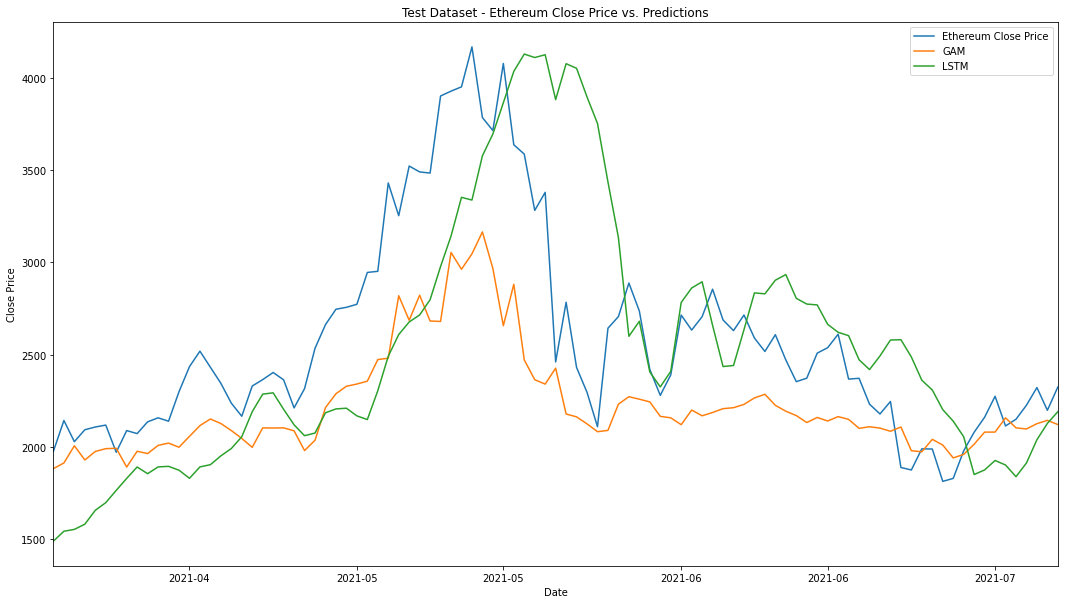

In [216]:
fig, ax = plt.subplots(figsize=(18, 10))

ax.plot(test["date"], y_test, label="Ethereum Close Price")
ax.plot(test["date"], gam_predictions_test, label="GAM")
ax.plot(test["date"], lstm_pred_test, label="LSTM")
ax.set(xlabel="Date",
       ylabel="Close Price",
       title="Test Dataset - Ethereum Close Price vs. Predictions",
       xlim=[min(test["date"]), max(test["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()